# Additional Example of FDTrees
This tutorial will explain the mathematics and API of FD-Trees in more detail.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from shap.maskers import Independent
from sklearn.neural_network import MLPRegressor

from pyfd.features import Features
from pyfd.fd_trees import CoE_Tree, PDP_PFI_Tree, GADGET_PDP
from pyfd.decompositions import get_components_brute_force, get_PDP_PFI_importance, get_regional_decompositions
from pyfd.shapley import get_SHAP_importance
from pyfd.plots import setup_pyplot_font, bar, attrib_scatter_plot, plot_legend, COLORS

 We first generate toy data following $x_i \sim U(-1, 1)$ for $i=1, 2, 3, 4$
 and $$y=
   \begin{cases}
         \sin(\pi x_3) & \text{if  } x_1\geq 0 \,\text{and}\, x_2 \geq 0\\
         -2x_3^2 + x_4 & \text{otherwise},
   \end{cases}$$
 These labels will be fit by a Multi-Layered Perceptron $h$ which is the model we are going to explain.

In [23]:
# Generate the data
np.random.seed(42)
d = 4
latex_feature_names = ["x_1", "x_2", "x_3", "x_4"]
X = np.random.uniform(-1, 1, size=(1000, d))
features = Features(X, latex_feature_names, ["num"]*d)
def h(X):
    y_hat = np.zeros((X.shape[0]))
    mask = (X[:, 0] > 0) & (X[:, 1] > 0)
    y_hat[mask] = np.sin(np.pi * X[mask, 2])
    y_hat[~mask] = -2 * X[~mask, 2]**2 + X[~mask, 3]
    return y_hat
y = h(X)
model = MLPRegressor(hidden_layer_sizes=(100, 50, 20, 10), max_iter=500).fit(X, y)
h = lambda x : model.predict(x)

 The vanilla `PyFD` pipeline employs the whole dataset (or a random subsample) as the background
 distribution.

In [24]:
# B is the empirical distribution over the whole dataset
background = X

# Compute the Interventional Decomposition
decomposition = get_components_brute_force(h, X, X, features)

# Compute the Shapley Values with the SHAP library
masker = Independent(background, max_samples=background.shape[0])
explainer = shap.explainers.Exact(h, masker)
shapley_values = explainer(background).values

ExactExplainer explainer: 1001it [00:28, 21.03it/s]                                                                                                                                                                 


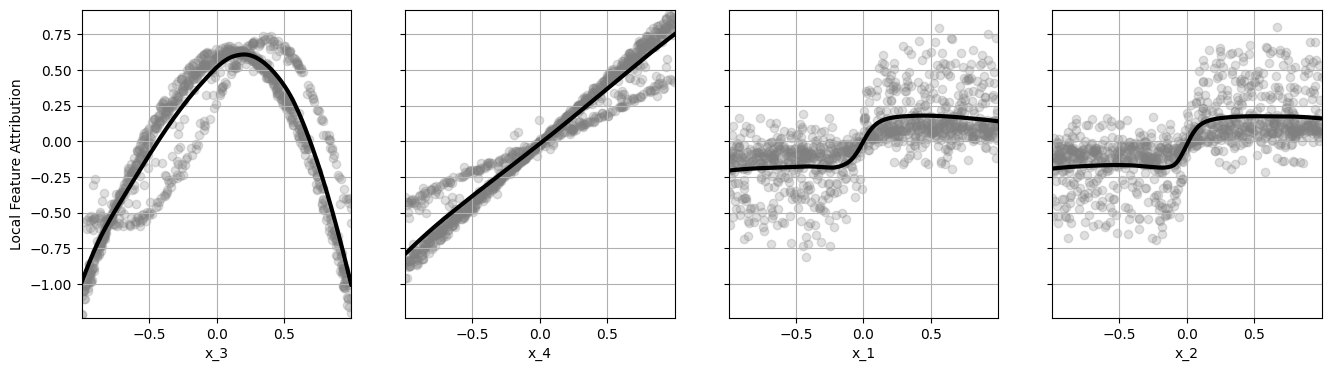

In [25]:
# Plot the PDP alongside SHAP
attrib_scatter_plot(decomposition, shapley_values, X, features, figsize=(16, 4))

In this plot, the lines are the PDP while the points are SHAP values. We observe strong disagreements between both explanation methods. This disagreement also translates to the PDP/SHAP/PFI global feature importance.

Text(0.5, 23.52222222222222, 'Feature Importance')

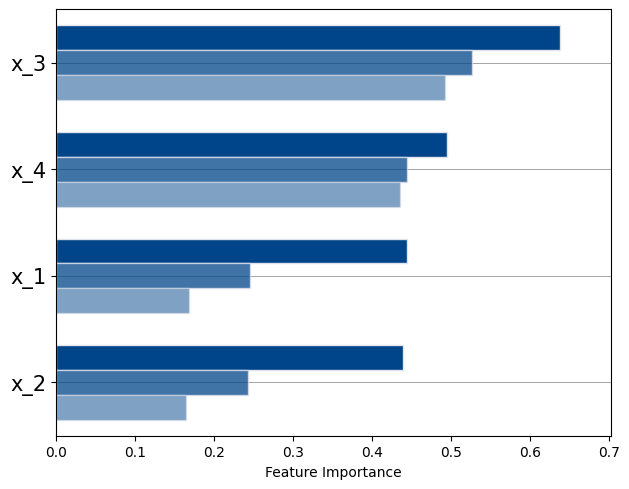

In [27]:
# Global feature importance
I_PDP, I_PFI  = get_PDP_PFI_importance(decomposition)
I_SHAP = get_SHAP_importance(shapley_values)
bar([I_PFI, I_SHAP, I_PDP], features.names())
plt.yticks(fontsize=15)
plt.xlabel("Feature Importance")

We saw in the previous tutorial that **feature interactions** are the culprit that prohibit agreement among the
PDP/SHAP/PFI methods. We also presented Lack of Addivity (LoA) scores which take as input a distribution $\mathcal{B}$ and return the strength of interactions $L_h(\mathcal{B})$.

The intuition behind FD-Trees is that, although the LoA $L_h(\mathcal{B})$ might be large when $\mathcal{B}$ is the empirical distribution over the dataset, it might be considerably lower when restricting $\mathcal{B}$ to a region $\Omega$. More formally, we let $\Omega$ be a rectangular region and $\mathcal{B}_{\Omega}$ be the restriction of
$\mathcal{B}$ to $\Omega$ (if $\mathcal{B}$ is the empirical distribution over the data, $\mathcal{B}_{\Omega}$ is the empirical distribution over all data that lands in $\Omega$). Then, we search for large regions ($\mathcal{B}(\Omega)$ is large) but with significantly smaller LoA than the original distribution $L_h(\mathcal{B}_{\Omega})\ll L_h(\mathcal{B})$. These regions $(\Omega_1, \Omega_2,\ldots,\Omega_\ell)$ are defined as the leaves of a decision tree.

<p align="center">
    <img src="./Images/FDTree.png" width="400">
</p>

This tree has a maximal depth of $D$. We can now restrict the background distribution to each individual leaf

<p align="center">
    <img src="./Images/Regional_Backgrounds.png" width="400">
</p>

and minimize the weighted average LoA across all leaves.

$$\min_{(\Omega_1, \ldots,\Omega_\ell):\ell\leq 2^D} \sum_{j=1}^\ell \mathcal{B}(\Omega_j)\times L_h(\mathcal{B}_{\Omega_j}) + \alpha \ell,$$

where $\alpha$ is a regularization hyperparameter that penalizes the number of leaves $\ell$ used by the FD-Tree.

In [28]:
# The arguments of the FD-Trees constructor are as follows
#
# Parameters
# ----------
# features : Feature object
# max_depth : int, default=3
#     Maximum depth of FDTrees
# min_samples_leaf : int, default=20
#     The minimum number of samples allowed per leaf
# branching_per_node : int, default=1
#     At each node, we consider `branching_per_node` different splits candidates.
#     A value of `1` corresponds to greedy CART-like optimization, while larger values
#     allow to try various splits and return a more optimal solution. Note that the training
#     scales as `O(branching_per_node^max_depth)`
# alpha : float, default=0.05
#     Objective regularization `LoA + alpha l` so splitting nodes increases the loss by
#     `alpha` and reductions in `LoA` must be large enough to compensate.
# save_losses : bool, default=False
#     Save the losses when searching for the optimal split along the various coordinates.
#     This is useful to understanding and debugging the training of the FD-Tree.

tree = CoE_Tree(features, max_depth=2, save_losses=True, branching_per_node=2)
# tree = PDP_PFI_Tree(features, max_depth=2, save_losses=True, branching_per_node=2)
# tree = GADGET_PDP(features, max_depth=2, save_losses=True, branching_per_node=2)

# The arguments of the .fit method are as follows
# Parameters
# ----------
# X : (N, d) np.ndarray
#     The background data on which to fit the tree.
# decomposition : dict{Tuple: np.ndarray}
#     The functional decomposition used to compute the LoA.
#     It needs to be anchored with foreground=background i.e.
#     `decomposition[(0,)].shape = (N, N)`.

tree.fit(X, decomposition)
tree.print(verbose=True)


LoA 0.3167
Samples 1000
If x_2 ≤ -0.0034:
|   LoA 0.0028
|   Samples 500
|   Region 0
else:
|   LoA 0.1961
|   Samples 500
|   If x_1 ≤ 0.0010:
|   |   LoA 0.0039
|   |   Samples 250
|   |   Region 1
|   else:
|   |   LoA 0.0101
|   |   Samples 250
|   |   Region 2
Final LoA 0.0167


 Once a FDTree is fitted, it can be used to partition
 the data samples into regions. The method `.predict()`
 returns the group index for each datum. Moreover, the `.rules()`
 method returns an interpretable representation of the regions.

In [29]:
regions = tree.predict(X)
print(regions[:10])
n_regions = tree.n_regions
rules = tree.rules()
print(rules)

[1 0 2 0 1 0 1 0 1 0]
{0: 'x_2<=-0.00', 1: '(x_2>-0.00 & x_1<=0.00)', 2: '(x_2>-0.00 & x_1>0.00)'}


Given these regions, instead of using the whole dataset as background, we can iterate over all regions and
only study the samples that land in each region. Since Interventional Decompositions have already been computed, 
we can use the `get_regional_decompositions` to transform the decomposition into three regional decompositions.

In [30]:
regional_decompositions = get_regional_decompositions(decomposition, regions, regions, n_regions)
del decomposition

 We must iterate over each regions to get the regional feature importance.

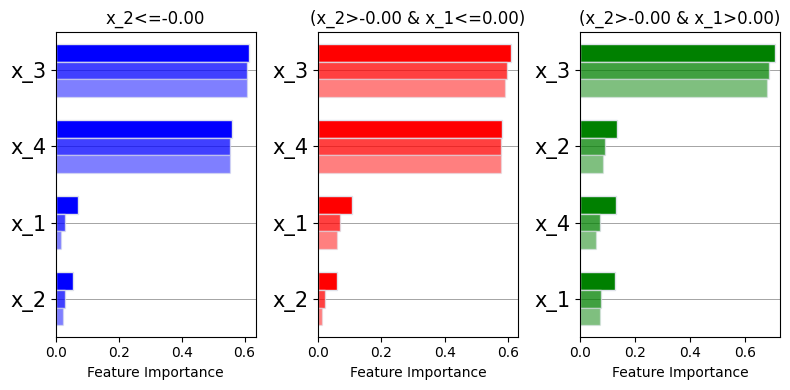

In [31]:
fig, axes = plt.subplots(1, tree.n_regions, figsize=(8, 4))
# Rerun SHAP and recompute global importance regionally
regional_shapley_values = [0] * tree.n_regions
regional_backgrounds = [0] * tree.n_regions
for r in range(tree.n_regions):
    regional_backgrounds[r] = X[regions == r]

    I_PDP, I_PFI = get_PDP_PFI_importance(regional_decompositions[r])

    # Rerun SHAP
    masker = Independent(regional_backgrounds[r], max_samples=regional_backgrounds[r].shape[0])
    explainer = shap.explainers.Exact(h, masker)
    regional_shapley_values[r] = explainer(regional_backgrounds[r]).values
    I_SHAP = get_SHAP_importance(regional_shapley_values[r])

    bar([I_PFI, I_SHAP, I_PDP], features.names(), ax=axes[r], color=COLORS[r])
    axes[r].set_xlim(0, np.max(I_PFI)+0.02)
    axes[r].set_xlabel("Feature Importance")
    axes[r].set_title(rules[r])

 Finally, we recompare the PDP and SHAP local feature attributions.

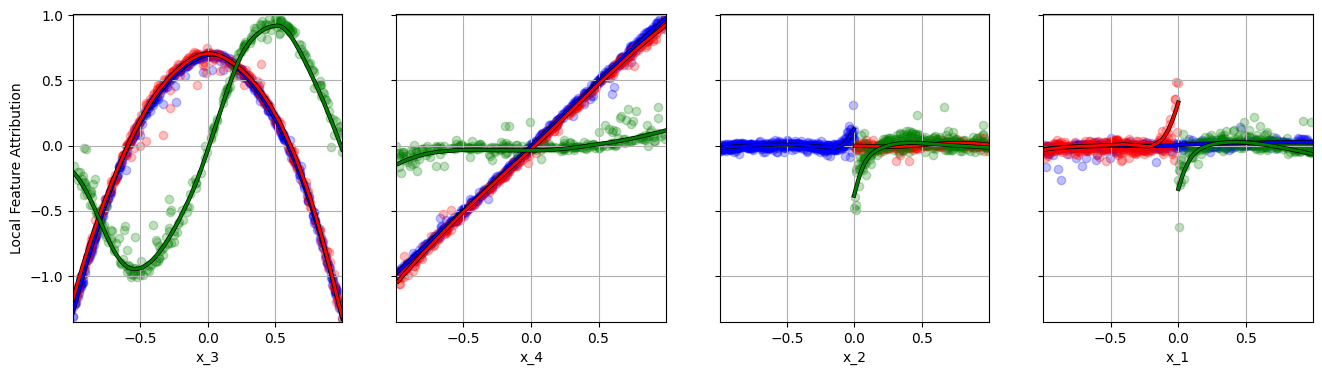

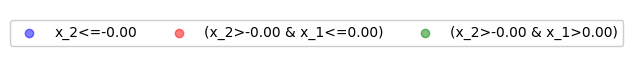

In [32]:
attrib_scatter_plot(regional_decompositions, regional_shapley_values,
                    regional_backgrounds, features, figsize=(16, 4))
plot_legend(rules, ncol=3)

 As a result of explaining the model regionally, we have reduced the
 disagreement between the post-hoc explainers.